<center><table border="0" style="width:100%">
 <tr>
    <td><img src="agh_znk_wbr_rgb_150ppi.jpg" height=100 width=100></td>
    <td><center><h2> Akademia Górniczo-Hutnicza <br> im. Stanisława Staszica w Krakowie</h2></center></td>
    <td><img src="logo_wz.png" height=100 width=100></td>
 </tr>
</table></center>

<center><h2>Wydział Zarządzania</h2></center>

<p style="margin-bottom:120px;"></p>

<center><h1>Uczenie maszynowe</h1></center>
<hr>

<p style="margin-bottom:240px;"></p>

<center><h3>Bartłomiej Fatyga, Mateusz Gaudyn, Krzysztof Paweł Skwarka<br></h3>
<h2>Zastosowanie metod poznanych na wykładach na przykładzie predykcji stanu pomp wodnych w Tanzanii</h2></center>

<p style="margin-bottom:240px;"></p>
<center>Kraków, styczeń 2021</center>

# 1. Wstęp

## 1.1 Wczytanie bibliotek

In [84]:
%config IPCompleter.greedy=True
# ladowanie bibliotek
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from scipy import stats
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc
# COMPLETE dopisac tutaj wszystkie biblioteki (te z dolu)

## 1.2 Wczytanie danych

In [85]:
#load data
data = pd.read_csv('full_data.csv')
#data.head()
print(data.columns.tolist())

['Unnamed: 0', 'id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


## 1.3 Wstępny dobór zmiennych

In [86]:
# wybranie danych
data_full = data[['id', 'status_group', 'amount_tsh', 'date_recorded', 'gps_height',
 'longitude', 'latitude', 'basin', 'region', 'ward', 'population', 'public_meeting',
 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'management',
 'payment', 'payment_type', 'water_quality', 'quantity', 'quantity_group', 'source',
 'waterpoint_type']]

data_full.head()
#data_full.columns

id    status_group  amount_tsh date_recorded  gps_height  longitude  \
0  69572      functional      6000.0    2011-03-14        1390  34.938093   
1   8776      functional         0.0    2013-03-06        1399  34.698766   
2  34310      functional        25.0    2013-02-25         686  37.460664   
3  67743  non functional         0.0    2013-01-28         263  38.486161   
4  19728      functional         0.0    2011-07-13           0  31.130847   

    latitude                    basin   region        ward  ...  \
0  -9.856322               Lake Nyasa   Iringa    Mundindi  ...   
1  -2.147466            Lake Victoria     Mara       Natta  ...   
2  -3.821329                  Pangani  Manyara     Ngorika  ...   
3 -11.155298  Ruvuma / Southern Coast   Mtwara    Nanyumbu  ...   
4  -1.825359            Lake Victoria   Kagera  Nyakasimbi  ...   

   construction_year extraction_type management         payment  payment_type  \
0               1999         gravity        vwc    pay annually      annually   
1               2010         gravity        wug       never pay     never pay   
2               2009         gravity        vwc  pay per bucket    per bucket   
3               1986     submersible        vwc       never pay     never pay   
4                  0         gravity      other       never pay     never pay   

  water_quality      quantity quantity_group                source  \
0          soft        enough         enough                spring   
1          soft  insufficient   insufficient  rainwater harvesting   
2          soft        enough         enough                   dam   
3          soft           dry            dry           machine dbh   
4          soft      seasonal       seasonal  rainwater harvesting   

               waterpoint_type  
0           communal standpipe  
1           communal standpipe  
2  communal standpipe multiple  
3  communal standpipe multiple  
4           communal standpipe  

[5 rows x 24 columns]

In [87]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 59400 non-null  int64  
 1   status_group       59400 non-null  object 
 2   amount_tsh         59400 non-null  float64
 3   date_recorded      59400 non-null  object 
 4   gps_height         59400 non-null  int64  
 5   longitude          59400 non-null  float64
 6   latitude           59400 non-null  float64
 7   basin              59400 non-null  object 
 8   region             59400 non-null  object 
 9   ward               59400 non-null  object 
 10  population         59400 non-null  int64  
 11  public_meeting     56066 non-null  object 
 12  scheme_management  55523 non-null  object 
 13  permit             56344 non-null  object 
 14  construction_year  59400 non-null  int64  
 15  extraction_type    59400 non-null  object 
 16  management         594

## 1.4 Brakujące wartości

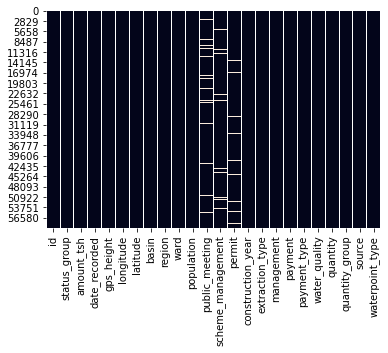

In [88]:
# nans
data_full.isnull().sum()

# niby ladny wykres NA, ale srednio dziala, kiedys bledy znalazlem, mimo, ze kod wydaje sie
# byc ok
sns.heatmap(data_full.isnull(), cbar=False)
plt.show()

In [89]:
# zwrocmy uwage, ze na wskazuje tylko w trzech kolumnach, a analiza wizualna wskazala, ze jest ich wiecej jednak tylko sa zle opisane
# dlatego dosc barbarzynsko puscilem value_counts po wszystkich kolumnach
for i in data_full.columns:
    print('Kolumna: ', i)
    print(data_full[i].value_counts())
    print('\n --------------------------------------------------')

Kolumna:  id
2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64

 --------------------------------------------------
Kolumna:  status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

 --------------------------------------------------
Kolumna:  amount_tsh
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

 --------------------------------------------------
Kolumna:  date_recorded
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-17      1
2012-01-25      1
2011-09-05      1
2013-12-01      1
2011-09-25      1
Name: date_recorded, Length: 3

In [90]:
# jak widzimy potencjalne (jeszcze trzeba sprawdzic numeryczne) braki sa w kolumnach:
# amount_tsh (0.0), longitude (0), latitude (-2.000000e-08) (widac na mapie jak sie oddali), population (0), scheme_management (None), contruction_year (0), management (unknown?),
# payment (unknown?), payment_type (unknown?), water_quality (unknown?), quantity (unknown?), quantity_group (unknown?), source (unknown?)
# sprawdzic jeszcze,  czy w amount_tsh 0 to na pewno na 
# podmienmy je wiec (wyswietli sie ostrzezenie, ogolnie nie powinno byc problemu, ale jak bedzie czas mozna pomyslec, by zrobic to 
# efektywniej)
# TODO sprawdzic amount_tsh
data_full['longitude'].replace(0, np.nan, inplace=True)
data_full['latitude'].replace(-2.000000e-08, np.nan, inplace=True)
data_full['population'].replace(0, np.nan, inplace=True)
data_full['construction_year'].replace(0, np.nan, inplace=True)
data_full['scheme_management'].replace('None', np.nan, inplace=True)
data_full['management'].replace('unknown', np.nan, inplace=True)
data_full['payment'].replace('unknown', np.nan, inplace=True)
data_full['payment_type'].replace('unknown', np.nan, inplace=True)
data_full['water_quality'].replace('unknown', np.nan, inplace=True)
data_full['quantity'].replace('unknown', np.nan, inplace=True)
data_full['quantity_group'].replace('unknown', np.nan, inplace=True)
data_full['source'].replace('unknown', np.nan, inplace=True)

D:\Users\konta\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [91]:
# nowe na
data_full.isnull().sum()

id                       0
status_group             0
amount_tsh               0
date_recorded            0
gps_height               0
longitude             1812
latitude              1812
basin                    0
region                   0
ward                     0
population           21381
public_meeting        3334
scheme_management     3878
permit                3056
construction_year    20709
extraction_type          0
management             561
payment               8157
payment_type          8157
water_quality         1876
quantity               789
quantity_group         789
source                  66
waterpoint_type          0
dtype: int64

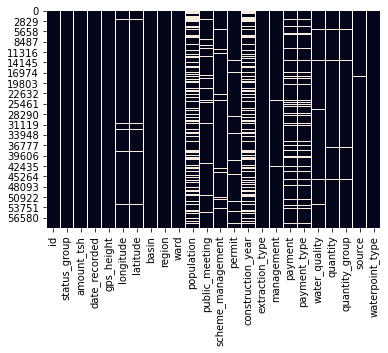

In [92]:
# nowy wykres na
sns.heatmap(data_full.isnull(), cbar=False)
plt.show()

## 1.5 Analiza opisowa

In [93]:
data_full.describe()

id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  57588.000000  57588.000000   
mean   37115.131768     317.650385    668.297239     35.149669     -5.885572   
std    21453.128371    2997.574558    693.116350      2.607428      2.809876   
min        0.000000       0.000000    -90.000000     29.607122    -11.649440   
25%    18519.750000       0.000000      0.000000     33.285100     -8.643841   
50%    37061.500000       0.000000    369.000000     35.005943     -5.172704   
75%    55656.500000      20.000000   1319.250000     37.233712     -3.372824   
max    74247.000000  350000.000000   2770.000000     40.345193     -0.998464   

         population  construction_year  
count  38019.000000       38691.000000  
mean     281.087167        1996.814686  
std      564.687660          12.472045  
min        1.000000        1960.000000  
25%       40.000000        1987.000000  
50%      150.000000        2000.000000  
75%      324.000000        2008.000000  
max    30500.000000        2013.000000

## Zamiana NA
Tworzymy macierz X i y

In [94]:
X = data_full.iloc[:, 2:]
y = data_full['status_group']

In [95]:
from sklearn.impute import SimpleImputer
X.select_dtypes(include=['float64', 'int64'])

amount_tsh  gps_height  longitude   latitude  population  \
0          6000.0        1390  34.938093  -9.856322       109.0   
1             0.0        1399  34.698766  -2.147466       280.0   
2            25.0         686  37.460664  -3.821329       250.0   
3             0.0         263  38.486161 -11.155298        58.0   
4             0.0           0  31.130847  -1.825359         NaN   
...           ...         ...        ...        ...         ...   
59395        10.0        1210  37.169807  -3.253847       125.0   
59396      4700.0        1212  35.249991  -9.070629        56.0   
59397         0.0           0  34.017087  -8.750434         NaN   
59398         0.0           0  35.861315  -6.378573         NaN   
59399         0.0         191  38.104048  -6.747464       150.0   

       construction_year  
0                 1999.0  
1                 2010.0  
2                 2009.0  
3                 1986.0  
4                    NaN  
...                  ...  
59395             1999.0  
59396             1996.0  
59397                NaN  
59398                NaN  
59399             2002.0  

[59400 rows x 6 columns]

In [96]:
# outliery z-score
z = np.abs(stats.zscore(data_full.loc[:, ['amount_tsh', 'gps_height', 'population', 'construction_year']]))
np.where(z > 3)
zz = z[:,0:2]

data_no_outliers = data_full[(zz < 3).all(axis=1)]
# TODO sprobowac inne metody na usuwanie outlierow

<AxesSubplot:xlabel='status_group', ylabel='construction_year'>

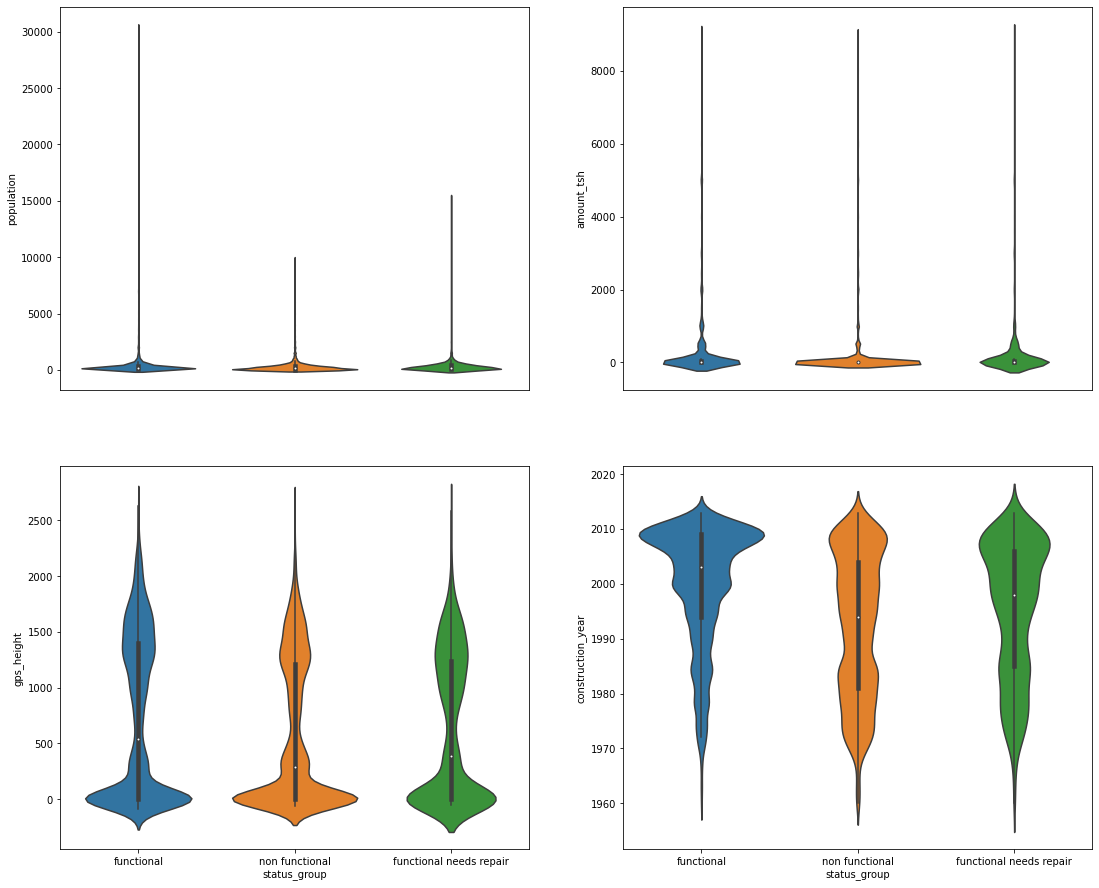

In [97]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 15.5)

sns.violinplot(x='status_group', y='population', data=data_no_outliers, ax=axs[0, 0])
axs[0, 0].get_xaxis().set_visible(False)
sns.violinplot(x='status_group', y='amount_tsh', data=data_no_outliers, ax=axs[0, 1])
axs[0, 1].get_xaxis().set_visible(False)
sns.violinplot(x='status_group', y='gps_height', data=data_no_outliers, ax=axs[1, 0])
sns.violinplot(x='status_group', y='construction_year', data=data_no_outliers[data_no_outliers['construction_year'] > 1900], ax=axs[1, 1])
# TODO po wyrzuceniu wszystkie na serwerze jupyter sprawdzic jak wyglada po usunieciu roku

In [98]:
#probka danych
data_sample = data_no_outliers.sample(n=1000)

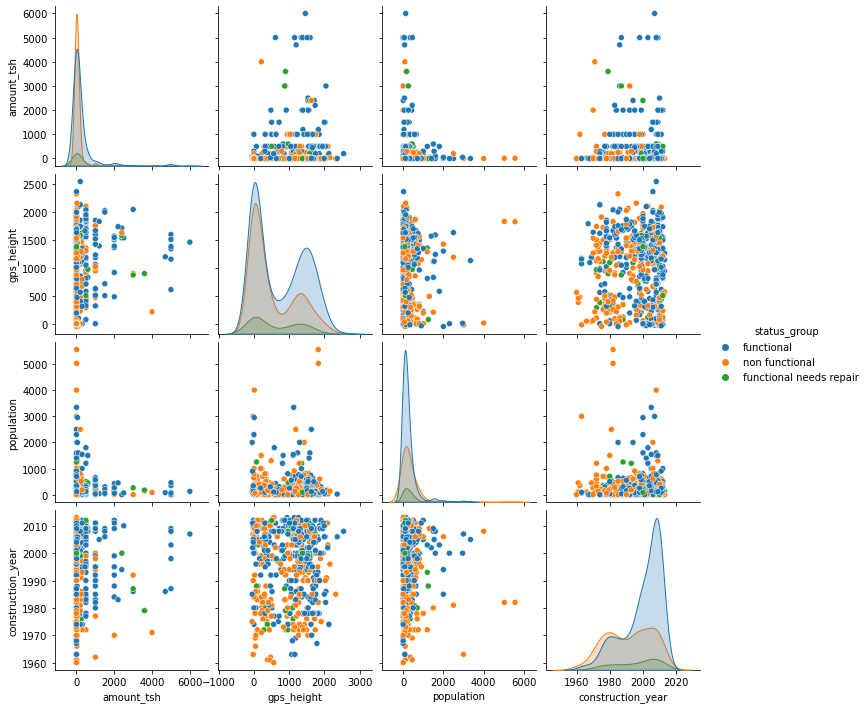

In [99]:
#gurwa to nie jest jak ggpair w R, gowno tylko do ilosciowych
sns.pairplot(data_sample[['status_group', 'amount_tsh', 'gps_height', 'population', 
                          'construction_year']], hue='status_group')

In [100]:
#wykres samych studni jako czarne punkty
indexes = ~data_no_outliers['latitude'].isnull()
heatmap_data = data_no_outliers[indexes]
lng = heatmap_data['longitude'].mean()
lat = heatmap_data['latitude'].mean()

m = folium.Map(location=[lat, lng], zoom_start=6)
HeatMap(data=heatmap_data[['latitude', 'longitude']], radius=1, blur=1, gradient={0.0: 'black'}).add_to(m)
m

In [101]:
m_2 = folium.Map(location=[lat, lng], zoom_start=6)
HeatMap(data=heatmap_data[['latitude', 'longitude']], radius=14).add_to(m_2)
m_2

In [102]:
# mapa z nalozonymi non functional na heat mape wszystkich
data_full_non_functional = heatmap_data[data_full['status_group'] == 'non functional']

lng = heatmap_data['longitude'].mean()
lat = heatmap_data['latitude'].mean()

m_3 = folium.Map(location=[lat, lng], zoom_start=6)
HeatMap(data=heatmap_data[['latitude', 'longitude']], radius=14).add_to(m_3)
HeatMap(data=data_full_non_functional[['latitude', 'longitude']], radius=3, blur=3, gradient={0.5: 'black'}).add_to(m_3)
m_3

<ipython-input-102-9dd9cb81783d>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_full_non_functional = heatmap_data[data_full['status_group'] == 'non functional']


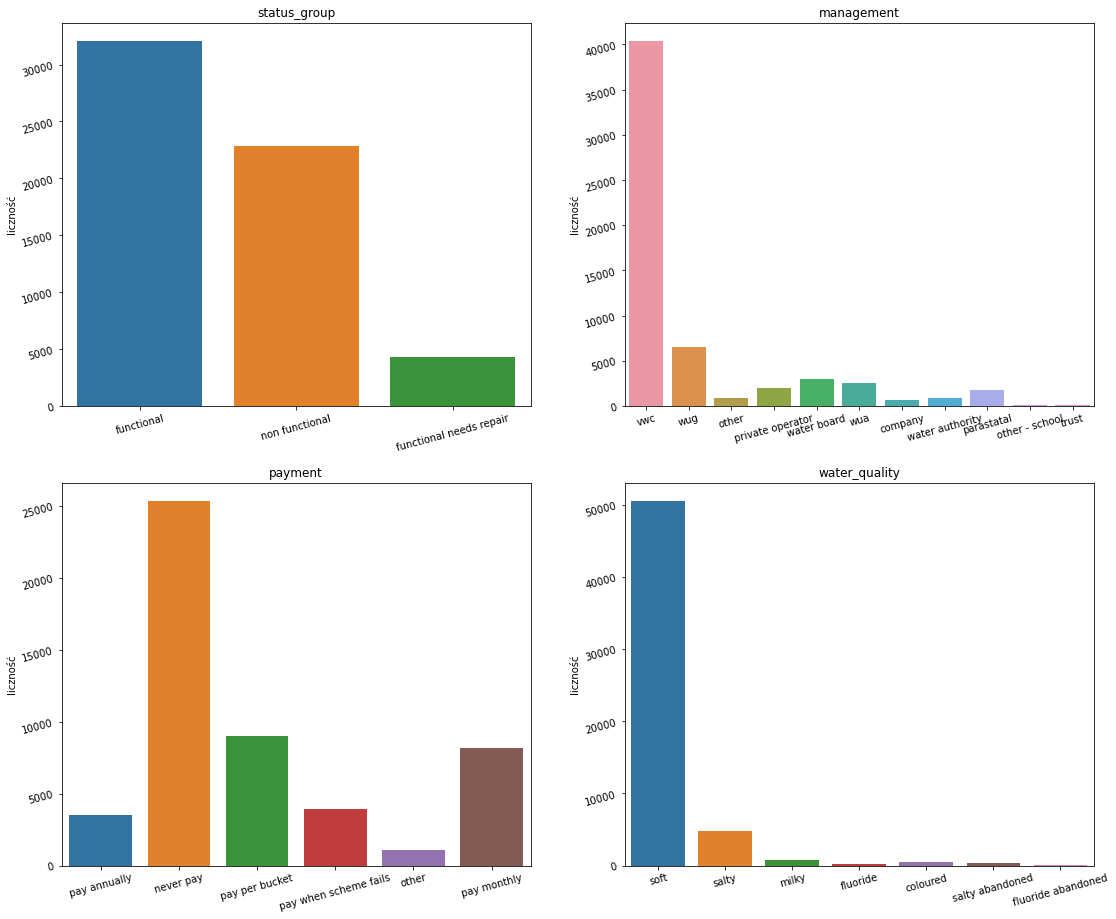

In [117]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 15.5)


sns.countplot(x = 'status_group', data = data_no_outliers, ax = axs[0,0])
axs[0,0].tick_params(labelrotation = 15)
axs[0,0].set_title("status_group")
sns.countplot(x = 'management', data = data_no_outliers, ax = axs[0,1])
axs[0,1].tick_params(labelrotation = 15)
axs[0,1].set_title("management")
sns.countplot(x = 'payment', data = data_no_outliers, ax = axs[1,0])
axs[1,0].tick_params(labelrotation = 15)
axs[1,0].set_title("payment")
sns.countplot(x = 'water_quality', data = data_no_outliers, ax = axs[1,1])
axs[1,1].tick_params(labelrotation = 15)
axs[1,1].set_title("water_quality")

for ax in axs.flat:
    ax.set(xlabel = '', ylabel='liczność')



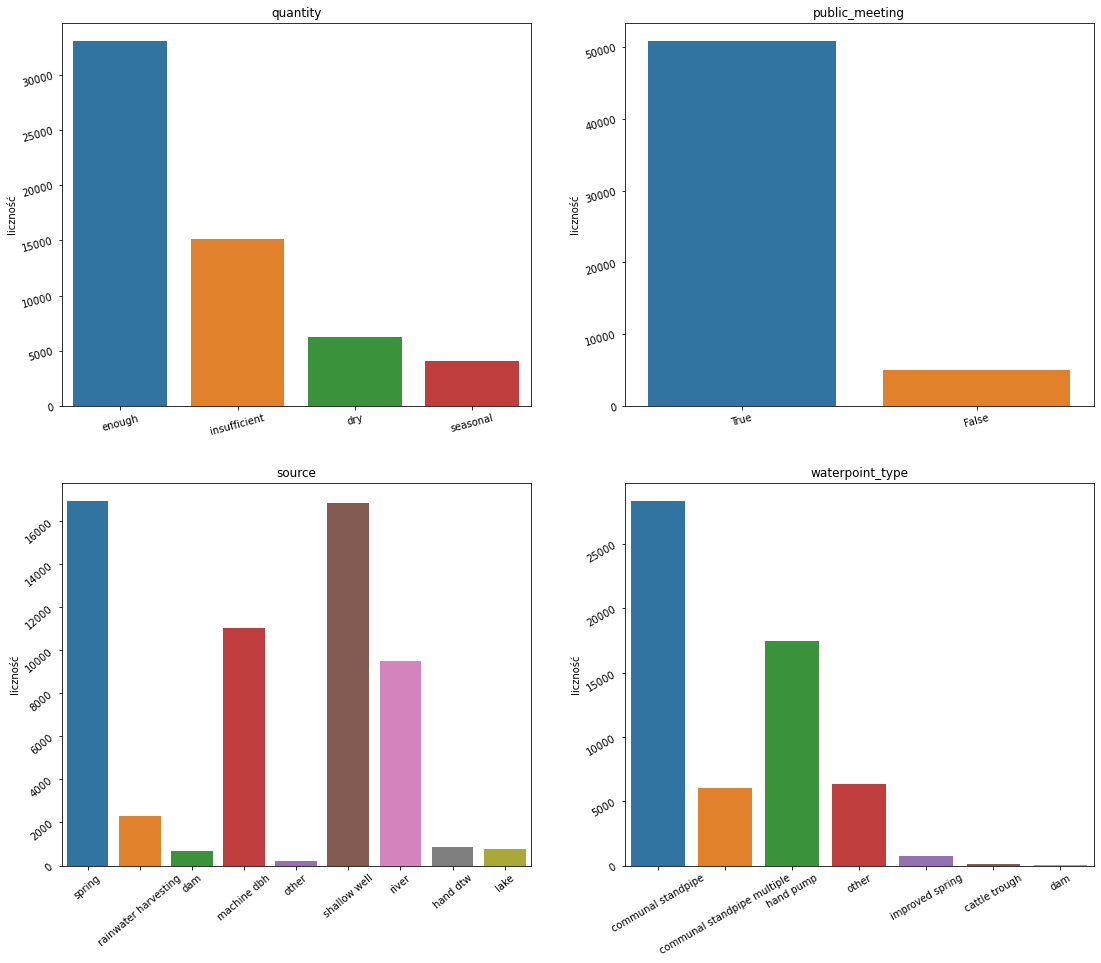

In [120]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 15.5)

sns.countplot(x = 'quantity', data = data_no_outliers, ax = axs[0,0])
axs[0,0].tick_params(labelrotation = 15)
axs[0,0].set_title("quantity")
sns.countplot(x = 'public_meeting', data = data_no_outliers, ax = axs[0,1])
axs[0,1].tick_params(labelrotation = 15)
axs[0,1].set_title("public_meeting")
sns.countplot(x = 'source', data = data_no_outliers, ax = axs[1,0])
axs[1,0].tick_params(labelrotation = 40)
axs[1,0].set_title("source")
sns.countplot(x = 'waterpoint_type', data = data_no_outliers, ax = axs[1,1])
axs[1,1].tick_params(labelrotation = 30)
axs[1,1].set_title("waterpoint_type")

for ax in axs.flat:
    ax.set(xlabel = '', ylabel='liczność')

    


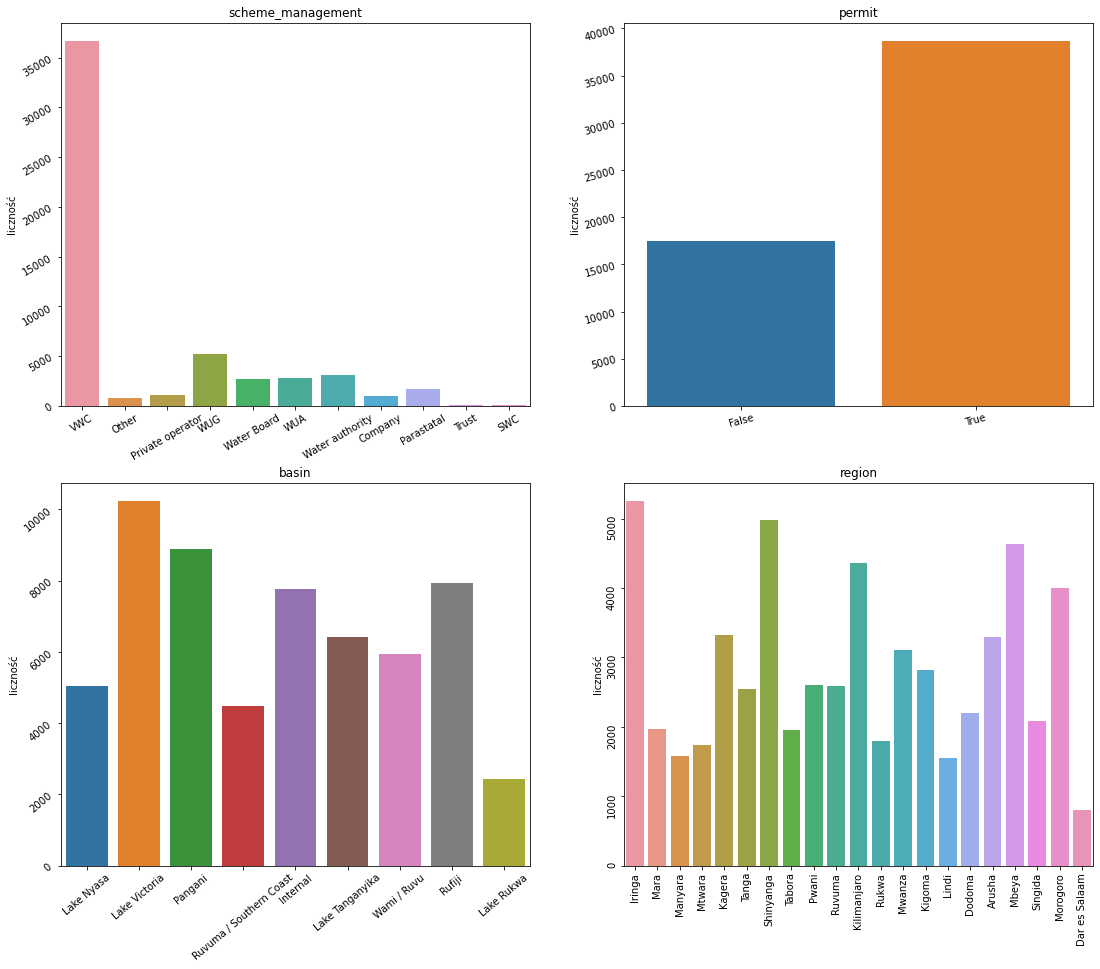

In [121]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 15.5)

sns.countplot(x = 'scheme_management', data = data_no_outliers, ax = axs[0,0])
axs[0,0].tick_params(labelrotation = 30)
axs[0,0].set_title("scheme_management")
sns.countplot(x = 'permit', data = data_no_outliers, ax = axs[0,1])
axs[0,1].tick_params(labelrotation = 15)
axs[0,1].set_title("permit")
sns.countplot(x = 'basin', data = data_no_outliers, ax = axs[1,0])
axs[1,0].tick_params(labelrotation = 40)
axs[1,0].set_title("basin")
sns.countplot(x = 'region', data = data_no_outliers, ax = axs[1,1])
axs[1,1].tick_params(labelrotation = 90)
axs[1,1].set_title("region")

for ax in axs.flat:
    ax.set(xlabel = '', ylabel='liczność')

In [104]:
# date_recorded
# status_group[]

#fig, axs = plt.subplots(2)
#fig.set_size_inches(10.5, 7.5)


#sns.countplot(x = 'date_recorded', data = data_full, ax = axs[0])
#axs[0].tick_params(labelrotation = 15)
#axs[0].set_title("date_recorded")
#sns.countplot(x = 'ward', data = data_full, ax = axs[1])
#axs[1].tick_params(labelrotation = 15)
#axs[1].set_title("ward")

#for ax in axs.flat:
#    ax.set(xlabel = '', ylabel='liczność')

# TODO ten wykres raczej wywalic

<AxesSubplot:xlabel='management', ylabel='count'>

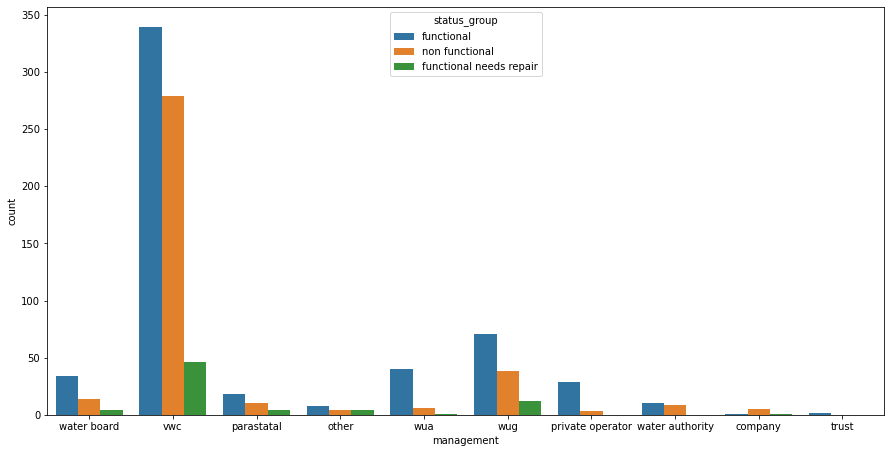

In [105]:
# takich wykresow raczej poszukujemy
# musimy wiedziec jak sie rozbija zmienna objasniana
fig, ax = plt.subplots()
fig.set_size_inches(15.0, 7.5)
sns.countplot(x='management', hue='status_group', data=data_sample, ax=ax)
# TODO other/other-school

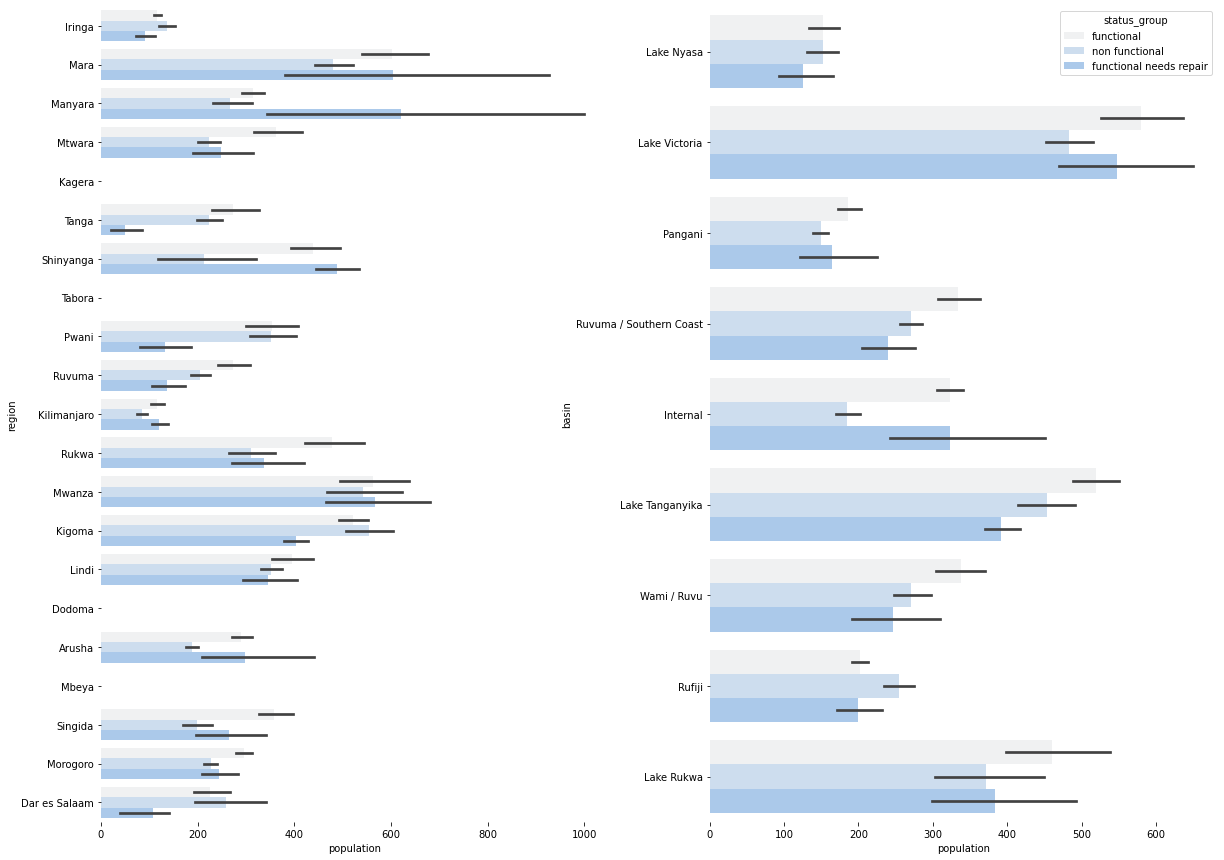

In [122]:
#sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
sns.set_color_codes("pastel")
sns.barplot(x="population", y="region", hue='status_group', data=data_no_outliers, color="b", ax=axs[0])
sns.despine(left=True, bottom=True)
sns.barplot(x="population", y="basin", hue='status_group', data=data_no_outliers, color="b", ax=axs[1])
sns.despine(left=True, bottom=True)
axs[0].get_legend().remove()
# TODO zastanowic sie nad sensem tego wykresu

In [107]:
#Zmiana na factory zmiennych payment_type, waterpoint_type, extraction_type, source
#coś sie rzuca python o .loc ale trudno
# ogólnie to nie musimy zamieniac na category, o ile wiem typ object potraktuje tak samo
# category na pewno jest szybsze i zajmuje mniej miejsca, ale kiedy to trzeba stosowac jest
# napisane w dokumentacji pandas (https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) 
# TODO sprawdzic jeszcze raz wszystkie kategoryczne (ja chyba bym to zakomentowal na teraz, bo troche komplikuje wybieranie kolumn xD)
#data_full.loc[:,"payment_type"] = data_full.loc[:,"payment_type"].astype('category')
#data_full.loc[:,"payment_type_cat"] = data_full.loc[:,"payment_type"].cat.codes
#data_full.loc[:,"extraction_type"] = data_full.loc[:,"extraction_type"].astype('category')
#data_full.loc[:,"extraction_type_cat"] = data_full.loc[:,"extraction_type"].cat.codes
#data_full.loc[:,"source"] = data_full.loc[:,"source"].astype('category')
#data_full.loc[:,"source_cat"] = data_full.loc[:,"source"].cat.codes
#
#data_full.loc[:,"waterpoint_type"] = data_full.loc[:,"waterpoint_type"].astype('category')
#print(data_full.dtypes)
#
#data_full.loc[:,"waterpoint_type_cat"] = data_full.loc[:,"waterpoint_type"].cat.codes
#data_full.head()

In [108]:
#from statsmodels.imputation.mice import MICEData
#imp = MICEData(data_full)

# Czy warto zmieniać dane czy raczej je wyrzucić?
# Sprawdzanie czy rozkład zmiennej objaśnianej różni się od rozkładu zmiennej objaśnianej z warunkiem występowania wartości
# NaN dla poszczególnych zmiennych

# Pasuje te wykresy co są niżej rzucać dwójkami obok siebie. Zajme się tym na dniach

# Zmienne gdzie występuje NaN
print(data_full.isnull().sum())
print('--------public_meeting.isnull() == True-------------------------')
print(data_full[data_full["public_meeting"].isnull() == True]["status_group"].value_counts())
print("----------------------------------------------------------------")
print(data_full["status_group"].value_counts())


id                       0
status_group             0
amount_tsh               0
date_recorded            0
gps_height               0
longitude             1812
latitude              1812
basin                    0
region                   0
ward                     0
population           21381
public_meeting        3334
scheme_management     3878
permit                3056
construction_year    20709
extraction_type          0
management             561
payment               8157
payment_type          8157
water_quality         1876
quantity               789
quantity_group         789
source                  66
waterpoint_type          0
dtype: int64
--------public_meeting.isnull() == True-------------------------
functional                 1678
non functional             1500
functional needs repair     156
Name: status_group, dtype: int64
----------------------------------------------------------------
functional                 32259
non functional             22824
functional nee

D:\Users\konta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status_group', ylabel='count'>

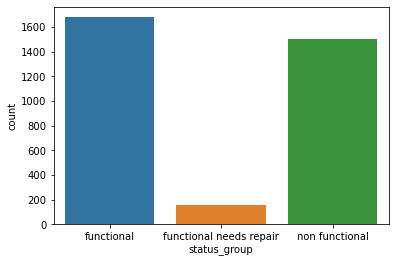

In [109]:
# Wykresy pokazują ze raczej pasuje te obserwacje zostawić, bo w przeciwieństwie do całego zbioru
# obserwacje gdzie public_meeting == NaN mają więcej przypadków non_functional niż funtional
sns.countplot(data_full[data_full["public_meeting"].isnull() == True]["status_group"], data=data_full)


Text(0.5, 1.0, 'permit')

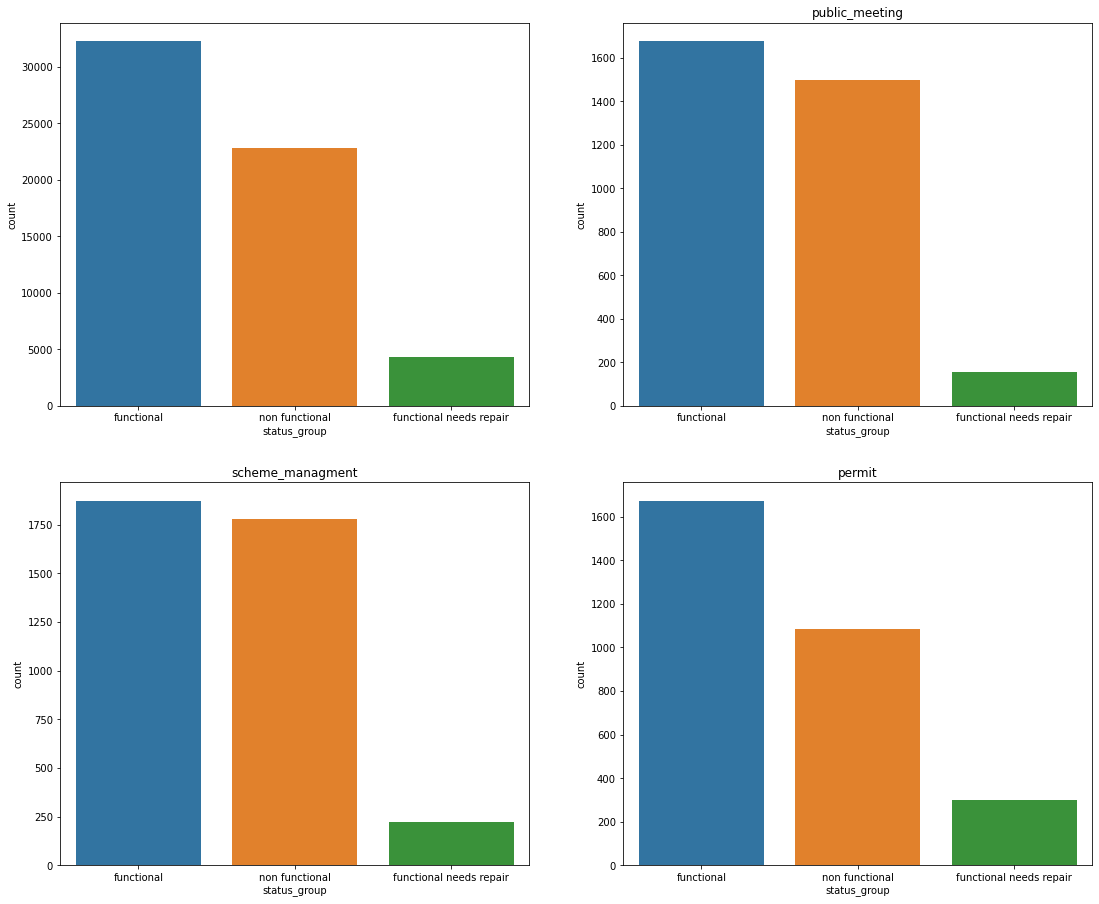

In [110]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(18.5, 15.5)

sns.countplot(x=data_full["status_group"], data=data_full, ax=axs[0, 0])
sns.countplot(x=data_full[data_full["public_meeting"].isnull() == True]["status_group"], data=data_full, ax=axs[0, 1], order=['functional', 'non functional', 'functional needs repair'])
axs[0, 1].set_title('public_meeting')
sns.countplot(x=data_full[data_full["scheme_management"].isnull() == True]["status_group"], data=data_full, ax=axs[1, 0])
axs[1, 0].set_title('scheme_managment')
sns.countplot(x=data_full[data_full["permit"].isnull() == True]["status_group"], data=data_full, ax=axs[1, 1], order=['functional', 'non functional', 'functional needs repair'])
axs[1, 1].set_title('permit')

In [111]:
# stworzmy najpierw dataset bez na
data_no_na = data_full.dropna()
data_no_na.isnull().sum()

id                   0
status_group         0
amount_tsh           0
date_recorded        0
gps_height           0
longitude            0
latitude             0
basin                0
region               0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
extraction_type      0
management           0
payment              0
payment_type         0
water_quality        0
quantity             0
quantity_group       0
source               0
waterpoint_type      0
dtype: int64

In [112]:
# zacznijmy od regresji logistycznej
# bedzie to mega wstepny model, bo trzeba dobrac zmienne jeszcze, a ten jest na wszystkich

X = data_no_na.iloc[:, 2:]
y = data_no_na['status_group']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipe = make_pipeline(
    OneHotEncoder(categories='auto', handle_unknown = 'ignore'),
    LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500))

In [114]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='ovr'))])

In [115]:
# dla train
y_pred = pipe.predict(X_train)
print("Accuracy score (train): ", accuracy_score(y_train, y_pred))

# dla test
y_pred = pipe.predict(X_test)
print("Accuracy score (test): ", accuracy_score(y_test, y_pred))

Accuracy score (train):  0.9380540540540541
Accuracy score (test):  0.7749122036874452


In [116]:
# TODO zrobic podmienianie NA
# TODO stworzyc model dla podmienionych NA
# TODO stworzyc inne modele